In [337]:
import math
import pandas as pd
import time
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from statistics import mean
from functools import lru_cache
import tempfile
from pathlib import Path
import os

In [338]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    """
    try:
        print(f"Loading data from '{filepath}'")
        df = pd.read_csv(filepath)
        print("Success!")
        return df
    except FileNotFoundError:
        print(f"Error: '{filepath}' not found.")
        return None

In [339]:
DATASET_PATH = 'M25_DA_A2_Part2.csv'

raw_df = load_data(DATASET_PATH)

if raw_df is not None:
    raw_df.info()

Loading data from 'M25_DA_A2_Part2.csv'
Success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Campaign_ID                        10000 non-null  object 
 1   Product_ID                         10000 non-null  object 
 2   Budget                             10000 non-null  float64
 3   Clicks                             10000 non-null  int64  
 4   Conversions                        10000 non-null  int64  
 5   Revenue_Generated                  10000 non-null  float64
 6   ROI                                10000 non-null  float64
 7   Customer_ID                        10000 non-null  object 
 8   Subscription_Tier                  10000 non-null  object 
 9   Subscription_Length                10000 non-null  int64  
 10  Flash_Sale_ID                      10000 non-null  object 
 11  Discou

In [340]:
raw_df.head()

,Campaign_ID,Product_ID,Budget,Clicks,Conversions,Revenue_Generated,ROI,Customer_ID,Subscription_Tier,Subscription_Length,Flash_Sale_ID,Discount_Level,Units_Sold,Bundle_ID,Bundle_Price,Customer_Satisfaction_Post_Refund,Common_Keywords
0,CMP_RLSDVN,PROD_HBJFA3,41770.45,4946,73,15520.09,1.94,CUST_1K7G39,Premium,4,FLASH_1VFK5K,43,34,BNDL_29U6W5,433.80,4,Affordable
1,CMP_JHHUE9,PROD_OE8YNJ,29900.93,570,510,30866.17,0.76,CUST_0DWS6F,Premium,4,FLASH_1M6COK,28,97,BNDL_ULV60J,289.29,2,Innovative
2,CMP_6SBOWN,PROD_4V8A08,22367.45,3546,265,32585.62,1.41,CUST_BR2GST,Basic,9,FLASH_J4PEON,51,160,BNDL_0HY0EF,462.87,4,Affordable
3,CMP_Q31QCU,PROD_A1Q6ZB,29957.54,2573,781,95740.12,3.32,CUST_6TBY6K,Premium,32,FLASH_1TOVXT,36,159,BNDL_AI09BC,334.16,1,Durable
4,CMP_AY0UTJ,PROD_F57N66,36277.19,818,79,81990.43,3.53,CUST_XASI45,Standard,29,FLASH_AOBHXL,20,52,BNDL_R03ITT,371.67,2,Affordable


In [341]:
raw_df[['Bundle_Price', 'Discount_Level', 'Customer_Satisfaction_Post_Refund']].describe()

,Bundle_Price,Discount_Level,Customer_Satisfaction_Post_Refund
count,10000.000000,10000.000000,10000.000000
mean,275.198346,39.421000,2.500900
std,129.218710,17.212925,1.113249
min,50.010000,10.000000,1.000000
25%,165.717500,24.000000,2.000000
50%,272.555000,39.000000,2.000000
75%,387.322500,54.000000,3.000000
max,499.970000,69.000000,4.000000


# Attribute-Oriented Induction (AOI)

In [342]:
# 1. Attributes to remove (high-cardinality / identifiers, no hierarchy planned)
ATTRIBUTES_TO_REMOVE = [
    'Campaign_ID',
    'Product_ID',
    'Customer_ID',
    'Flash_Sale_ID',
    'Bundle_ID',
    'Common_Keywords',
]

# 2. Concept Hierarchies (expanded for all major numeric columns)
CONCEPT_HIERARCHIES = {
    'Budget': {
        (0, 5000): 'Low',
        (5000, 20000): 'Medium',
        (20000, math.inf): 'High',
        'Low': 'ANY',
        'Medium': 'ANY',
        'High': 'ANY'
    },
    'Subscription_Length': {
        (0, 3): 'Short-Term',
        (3, 12): 'Mid-Term',
        (12, math.inf): 'Long-Term',
        'Short-Term': 'ANY',
        'Mid-Term': 'ANY',
        'Long-Term': 'ANY'
    },
    'ROI': {
        (-math.inf, 0): 'Loss',
        (0, 1): 'Break-even',
        (1, math.inf): 'Profitable',
        'Loss': 'ANY',
        'Break-even': 'ANY',
        'Profitable': 'ANY'
    },
    'Clicks': {
        (0, 100): 'Low',
        (100, 500): 'Medium',
        (500, math.inf): 'High',
        'Low': 'ANY',
        'Medium': 'ANY',
        'High': 'ANY'
    },
    'Conversions': {
        (0, 10): 'Low',
        (10, 50): 'Medium',
        (50, math.inf): 'High',
        'Low': 'ANY',
        'Medium': 'ANY',
        'High': 'ANY'
    },
    'Revenue_Generated': {
        (0, 1000): 'Low',
        (1000, 5000): 'Medium',
        (5000, math.inf): 'High',
        'Low': 'ANY',
        'Medium': 'ANY',
        'High': 'ANY'
    },
    'Units_Sold': {
        (0, 20): 'Low',
        (20, 100): 'Medium',
        (100, math.inf): 'High',
        'Low': 'ANY',
        'Medium': 'ANY',
        'High': 'ANY'
    },
    'Bundle_Price': {
        (0, 166): 'Low',
        (166, 388): 'Medium',
        (388, math.inf): 'High',
        'Low': 'ANY',
        'Medium': 'ANY',
        'High': 'ANY'
    },
    'Discount_Level': {
        (0, 25): 'Low',
        (25, 55): 'Medium',
        (55, math.inf): 'High',
        'Low': 'ANY',
        'Medium': 'ANY',
        'High': 'ANY'
    },
    'Customer_Satisfaction_Post_Refund': {
        (0, 2.5): 'Low',
        (2.5, 5): 'High',
        'Low': 'ANY',
        'High': 'ANY'
    },
    'Subscription_Tier': {
        'Basic': 'ANY',
        'Standard': 'ANY',
        'Premium': 'ANY'
    }
}

# 3. Generalization threshold (max allowed tuples after merging/generalizing)
GENERALIZATION_THRESHOLD = 5

# 4. Target class definition
TARGET_CLASS = {
    'attribute': 'ROI',
    'condition': lambda x: x > 2.0
}

In [343]:
def attribute_oriented_induction(
    df,
    target_class,
    attributes_to_remove,
    concept_hierarchies,
    generalization_threshold
):
    """
    Perform Attribute-Oriented Induction (AOI) on the input DataFrame.
    Returns a generalized DataFrame with vote counts.
    """
    # Step 1: Collect Task-Relevant Data
    working_df = df.copy()
    attr = target_class['attribute']
    cond = target_class['condition']
    working_df = working_df[working_df[attr].apply(cond)]

    # Step 2: Apply Initial Generalizations
    # Attribute Removal
    working_df = working_df.drop(columns=[col for col in attributes_to_remove if col in working_df.columns], errors='ignore')

    # First-Level Numeric Generalization
    for gen_attr in set(working_df.columns) & set(concept_hierarchies.keys()):
        hierarchy = concept_hierarchies[gen_attr]
        is_numeric_hierarchy = any(isinstance(k, tuple) for k in hierarchy.keys())
        if is_numeric_hierarchy:
            def to_category(val):
                for k, v in hierarchy.items():
                    if isinstance(k, tuple) and len(k) == 2:
                        low, high = k
                        if low < val <= high:
                            return v
                return val  # If not found, lite
            working_df[gen_attr] = working_df[gen_attr].apply(to_category)

    # Initialize Votes
    working_df['vote'] = 1

    # Step 3: Initial Merge
    group_cols = [col for col in working_df.columns if col != 'vote']
    working_df = working_df.groupby(group_cols, dropna=False, as_index=False)['vote'].sum()

    # Step 4: Iterative Generalization Loop
    while len(working_df) > generalization_threshold:
        # a. Select Attribute to Generalize
        candidate_attrs = [col for col in working_df.columns if col != 'vote' and col in concept_hierarchies]
        if not candidate_attrs:
            break
        attr_to_gen = max(candidate_attrs, key=lambda c: working_df[c].nunique())

        # b. Perform Generalization
        hierarchy = concept_hierarchies[attr_to_gen]
        def ascend(val):
            if val in hierarchy:
                return hierarchy[val]

            # Fallback for raw numeric values that might have slipped through
            for k, v in hierarchy.items():
                if isinstance(k, tuple) and len(k) == 2:
                    low, high = k
                    if low < val <= high:
                        return hierarchy.get(v, v)
            return val
        working_df[attr_to_gen] = working_df[attr_to_gen].apply(ascend)

        # c. Merge and Propagate Votes
        group_cols = [col for col in working_df.columns if col != 'vote']
        working_df = working_df.groupby(group_cols, dropna=False, as_index=False)['vote'].sum()

        # d. Prune 'ANY' Attributes
        for col in candidate_attrs:
            if working_df[col].nunique() == 1 and working_df[col].iloc[0] == 'ANY':
                working_df = working_df.drop(columns=[col])

    # Step 5: Return Final Result
    return working_df

In [344]:
aoi_result_df = attribute_oriented_induction(
    raw_df,
    TARGET_CLASS,
    ATTRIBUTES_TO_REMOVE,
    CONCEPT_HIERARCHIES,
    GENERALIZATION_THRESHOLD
)
aoi_result_df

,Revenue_Generated,ROI,Customer_Satisfaction_Post_Refund,vote
0,High,Profitable,High,3207
1,High,Profitable,Low,3239
2,Medium,Profitable,High,114
3,Medium,Profitable,Low,126


In [345]:
def format_rule(generalized_df):
    total_votes = generalized_df['vote'].sum()
    rule_parts = []
    for _, row in generalized_df.iterrows():
        conditions = []
        for col in generalized_df.columns:
            if col == 'vote':
                continue
            conditions.append(f"`{col}` = **{row[col]}**")
        conjunctive_clause = " <br> &nbsp;&nbsp;AND&nbsp;&nbsp; ".join(conditions)
        vote = row['vote']
        probability = (vote / total_votes) * 100 if total_votes > 0 else 0
        rule_parts.append(
            f"{conjunctive_clause}  <br> <span style='color:gray'>[vote: {vote}, probability: {probability:.1f}%]</span>"
        )
    rule_str = "### Characteristic Rule\n" + "<br>**OR**<br>".join(rule_parts)
    display(Markdown(rule_str))

format_rule(aoi_result_df)

### Characteristic Rule
`Revenue_Generated` = **High** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `ROI` = **Profitable** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `Customer_Satisfaction_Post_Refund` = **High**  <br> <span style='color:gray'>[vote: 3207, probability: 48.0%]</span><br>**OR**<br>`Revenue_Generated` = **High** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `ROI` = **Profitable** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `Customer_Satisfaction_Post_Refund` = **Low**  <br> <span style='color:gray'>[vote: 3239, probability: 48.4%]</span><br>**OR**<br>`Revenue_Generated` = **Medium** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `ROI` = **Profitable** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `Customer_Satisfaction_Post_Refund` = **High**  <br> <span style='color:gray'>[vote: 114, probability: 1.7%]</span><br>**OR**<br>`Revenue_Generated` = **Medium** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `ROI` = **Profitable** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `Customer_Satisfaction_Post_Refund` = **Low**  <br> <span style='color:gray'>[vote: 126, probability: 1.9%]</span>

In [346]:
def format_rule_filtered(generalized_df, min_probability=10):
    total_votes = generalized_df['vote'].sum()
    rule_parts = []
    for _, row in generalized_df.iterrows():
        vote = row['vote']
        probability = (vote / total_votes) * 100 if total_votes > 0 else 0
        if probability < min_probability:
            continue
        conditions = []
        for col in generalized_df.columns:
            if col == 'vote':
                continue
            conditions.append(f"`{col}` = **{row[col]}**")
        conjunctive_clause = " <br> &nbsp;&nbsp;AND&nbsp;&nbsp; ".join(conditions)
        rule_parts.append(
            f"{conjunctive_clause}  <br> <span style='color:gray'>[vote: {vote}, probability: {probability:.1f}%]</span>"
        )
    if not rule_parts:
        display(Markdown("No rules meet the minimum probability threshold."))
        return
    rule_str = "### Characteristic Rule (Filtered)\n" + "<br>**OR**<br>".join(rule_parts)
    display(Markdown(rule_str))

format_rule_filtered(aoi_result_df, min_probability=10)

### Characteristic Rule (Filtered)
`Revenue_Generated` = **High** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `ROI` = **Profitable** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `Customer_Satisfaction_Post_Refund` = **High**  <br> <span style='color:gray'>[vote: 3207, probability: 48.0%]</span><br>**OR**<br>`Revenue_Generated` = **High** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `ROI` = **Profitable** <br> &nbsp;&nbsp;AND&nbsp;&nbsp; `Customer_Satisfaction_Post_Refund` = **Low**  <br> <span style='color:gray'>[vote: 3239, probability: 48.4%]</span>

Attribute-Oriented Induction (AOI) is a data mining technique that transforms large volume of data into a high-level summary. Its purpose is to generate **characteristic rules** which describe common properties. This is done through data generalization where attribute values are replaced by more general concepts defined in concept hierarchies.

## Steps

1. **Data Focusing:** Selecting a task relevant subset of the data to be characterized.
2. **Generalization:** Iteratively "climbing" concept hierarchies or removing attributes to reduce the number of distinct rows.
3. **Vote Propagation:** Aggregating a vote count for each generalized row to represent how many original rows it summarizes.
4. **Threshold Termination:** Stopping the process when the data has been summarized to a predefined level of conciseness.

## Configuration

- `TARGET_CLASS` : The task relevant data is defined as marketing campaigns with a high return on investment. We selected all rows where `ROI > 2`. This focuses on characterizing only the most successful campaigns.

- `ATTRIBUTES_TO_REMOVE` : High-cardinality identifier columns (Campaign_ID, Product_ID, etc.) and noisy text fields (Common_Keywords) were removed. These attributes would prevent effective generalization.

- `CONCEPT_HIERARCHIES` : We defined generalization rules for all key numeric and categorical attributes.
    - **Data-Driven Bins:** For numeric attributes like Bundle_Price and Discount_Level, the generalization bins ('Low', 'Medium', 'High') were defined using the data's statistical distribution (specifically, the 25th and 75th percentiles).
    - **Categorical Generalization:** For nominal attributes like Subscription_Tier, a simple hierarchy was defined to map each specific tier ('Basic', 'Standard') to a top-level 'ANY' concept.

- `GENERALIZATION_THRESHOLD` : Set to 5, meaning the algorithm will continue generalizing until there are 5 or fewer distinct rows in the dataset.

## Algorithm

- **Initial Merge & Vote :** The function performs an initial groupby on the generalized data. All identical rows are merged, and their vote counts are summed.

- **Iterative Generalization :**  The while loop runs until the number of rows is less than or equal to `GENERALIZATION_THRESHOLD`. In each iteration:
    1. Selects the attribute with the highest number of distinct values for generalization. Generalizing the most diverse attribute is the fastest way to reduce the total number of unique rows.
    2. The values in the selected attribute's column are replaced by their parent concept from the defined hierarchy.
    3. The groupby and sum() operation is repeated to merge any rows that have become identical after the latest generalization step.
    4. If any attribute has been fully generalized (all values are `ANY`), the column is dropped.

## Analysis

The AOI reduced the 6,686 records of high-ROI campaigns (out of 10,000) into just 4 characteristic rules.

- 96.4% of high-ROI campaigns are characterized by generating 'High' revenue.
- Within the 'High' revenue group, customer satisfaction is almost evenly split between 'Low' and 'High', suggesting that customer satisfaction does not uniquely define a profitable campaign in this dataset.
- Achieving high ROI from medium-revenue campaigns is rare (3.6%).


---

# Bottom-Up Cube (BUC)

In [347]:
def preprocess_for_buc(df, concept_hierarchies):
    """
    Applies first-level generalization to prepare the DataFrame for BUC.
    """
    buc_df = df.copy()

    # Apply first-level generalization to all relevant columns
    for gen_attr in set(buc_df.columns) & set(concept_hierarchies.keys()):
        hierarchy = concept_hierarchies[gen_attr]

        is_numeric_hierarchy = any(isinstance(k, tuple) for k in hierarchy.keys())
        if is_numeric_hierarchy:
            def to_category(val):
                for k, v in hierarchy.items():
                    if isinstance(k, tuple) and len(k) == 2:
                        low, high = k
                        if low < val <= high:
                            return v
                return val
            buc_df[gen_attr] = buc_df[gen_attr].apply(to_category)

    print("DataFrame pre-processed for BUC.")
    return buc_df

# Create the discretized DataFrame
buc_df = preprocess_for_buc(raw_df, CONCEPT_HIERARCHIES)

# Display a sample of the processed data
buc_df.head()

DataFrame pre-processed for BUC.


,Campaign_ID,Product_ID,Budget,Clicks,Conversions,Revenue_Generated,ROI,Customer_ID,Subscription_Tier,Subscription_Length,Flash_Sale_ID,Discount_Level,Units_Sold,Bundle_ID,Bundle_Price,Customer_Satisfaction_Post_Refund,Common_Keywords
0,CMP_RLSDVN,PROD_HBJFA3,High,High,High,High,Profitable,CUST_1K7G39,Premium,Mid-Term,FLASH_1VFK5K,Medium,Medium,BNDL_29U6W5,High,High,Affordable
1,CMP_JHHUE9,PROD_OE8YNJ,High,High,High,High,Break-even,CUST_0DWS6F,Premium,Mid-Term,FLASH_1M6COK,Medium,Medium,BNDL_ULV60J,Medium,Low,Innovative
2,CMP_6SBOWN,PROD_4V8A08,High,High,High,High,Profitable,CUST_BR2GST,Basic,Mid-Term,FLASH_J4PEON,Medium,High,BNDL_0HY0EF,High,High,Affordable
3,CMP_Q31QCU,PROD_A1Q6ZB,High,High,High,High,Profitable,CUST_6TBY6K,Premium,Long-Term,FLASH_1TOVXT,Medium,High,BNDL_AI09BC,Medium,Low,Durable
4,CMP_AY0UTJ,PROD_F57N66,High,High,High,High,Profitable,CUST_XASI45,Standard,Long-Term,FLASH_AOBHXL,Low,Medium,BNDL_R03ITT,Medium,Low,Affordable


In [348]:
def buc_in_memory_baseline(df, dimensions, minsup):
    """
    Baseline full in-memory BUC:
    - Depth-first
    - Explores WITH / WITHOUT paths
    - Apriori pruning: stop recursion if partition < minsup
    Returns dict {cuboid_key(tuple of (dim,val) pairs): count}
    """
    results = {}
    n = len(df)
    if n >= minsup:
        results[()] = n

    def recurse(cur_df, remaining_dims, current_spec):
        if not remaining_dims:
            return
        dim = remaining_dims[0]
        tail = remaining_dims[1:]
        # WITH path
        for val, part in cur_df.groupby(dim):
            cnt = len(part)
            if cnt >= minsup:
                new_spec = dict(current_spec)
                new_spec[dim] = val
                key = tuple(sorted(new_spec.items()))
                if key not in results:
                    results[key] = cnt
                recurse(part, tail, new_spec)
        # WITHOUT path
        recurse(cur_df, tail, current_spec)

    recurse(df, dimensions, {})
    return results


def buc_out_of_memory(
    filepath, 
    dimensions, 
    minsup, 
    concept_hierarchies, 
    memory_limit_bytes=10 * 1024 * 1024 # 10 MB limit for switching to in-memory
):
    """
    An out-of-memory BUC implementation that uses disk-based partitioning.
    Switches to a faster in-memory algorithm for small partitions.
    """
    results = {}

    # Create a temporary directory to store partition files
    with tempfile.TemporaryDirectory() as temp_dir:

        # Pre-process the entire file once to create a clean, generalized version
        print("Performing initial data generalization for BUC...")
        processed_file_path = os.path.join(temp_dir, "processed_initial.csv")
        header = True
        # Use a larger chunksize for initial processing efficiency
        with pd.read_csv(filepath, chunksize=10000) as reader:
            for chunk in reader:
                processed_chunk = preprocess_for_buc(chunk, concept_hierarchies)
                processed_chunk[dimensions].to_csv(processed_file_path, mode='a', header=header, index=False)
                header = False
        print("Initial generalization complete. Starting BUC recursion.")

        def recurse_on_disk(partition_path, remaining_dims, current_spec):
            nonlocal results
            # Count rows without loading the whole file, slow but saves memory
            try:
                row_count = sum(1 for row in open(partition_path)) - 1 # Subtract header
            except (IOError, FileNotFoundError):
                return # File might not have been created if a partition was empty

            if row_count < minsup:
                return

            key = tuple(sorted(current_spec.items()))
            if key not in results:
                results[key] = row_count

            # Base Case: Switch to In-Memory
            file_size = os.path.getsize(partition_path)
            if not remaining_dims or (file_size < memory_limit_bytes and file_size > 0):
                try:
                    df_partition = pd.read_csv(partition_path)
                    if not df_partition.empty:
                        # Use the fast in-memory BUC for this small-enough subset
                        in_mem_results = buc_in_memory_baseline(df_partition, remaining_dims, minsup)

                        # Merge results with the correct prefix
                        for sub_key, count in in_mem_results.items():
                            full_spec = dict(current_spec)
                            full_spec.update(dict(sub_key))
                            final_key = tuple(sorted(full_spec.items()))
                            if final_key not in results:
                                results[final_key] = count
                except pd.errors.EmptyDataError:
                    pass # File might be empty or just a header
                return

            # Recursive Step: Partition on Disk
            dim = remaining_dims[0]
            tail = remaining_dims[1:]

            # "WITHOUT" Path: Recurse on the same data with fewer dimensions
            recurse_on_disk(partition_path, tail, current_spec)

            # "WITH" Path: Create sub-partitions on disk
            try:
                unique_vals = pd.read_csv(partition_path, usecols=[dim])[dim].unique()
            except (ValueError, pd.errors.EmptyDataError):
                unique_vals = [] # No data to partition

            partition_files = {val: os.path.join(temp_dir, f"{Path(partition_path).stem}_{hash(val)}.csv") for val in unique_vals}

            header_row = pd.read_csv(partition_path, nrows=0).columns.tolist()
            for fpath in partition_files.values():
                with open(fpath, 'w', newline='') as f:
                    pd.DataFrame(columns=header_row).to_csv(f, index=False)

            with pd.read_csv(partition_path, chunksize=5000) as reader:
                for chunk in reader:
                    for val, group in chunk.groupby(dim):
                        if val in partition_files:
                            group.to_csv(partition_files[val], mode='a', header=False, index=False)

            for val, fpath in partition_files.items():
                new_spec = dict(current_spec)
                new_spec[dim] = val
                recurse_on_disk(fpath, tail, new_spec)

        # Start the recursion on the fully pre-processed file
        recurse_on_disk(processed_file_path, dimensions, {})

    return results

In [349]:
buc_dimensions = [
    'Subscription_Tier',
    'Revenue_Generated',
    'Customer_Satisfaction_Post_Refund',
    'Discount_Level'
]
min_support = 500

print("Running In-Memory BUC...")
start_time = time.perf_counter()
in_memory_cube = buc_in_memory_baseline(buc_df[buc_dimensions], buc_dimensions, min_support)
end_time = time.perf_counter()
print(f"  Found {len(in_memory_cube)} cuboids in {end_time - start_time:.2f} seconds.")
print("  Sample:", list(in_memory_cube.items())[:5])

print("\nRunning Out-of-Memory BUC...")
start_time = time.perf_counter()
oom_cube = buc_out_of_memory(
    DATASET_PATH,
    buc_dimensions,
    min_support,
    CONCEPT_HIERARCHIES,
    memory_limit_bytes=5 * 1024 * 1024 # 5MB switchover threshold
)
end_time = time.perf_counter()
print(f"  Found {len(oom_cube)} cuboids in {end_time - start_time:.2f} seconds.")
print("  Sample:", list(oom_cube.items())[:5])

Running In-Memory BUC...


  Found 72 cuboids in 0.02 seconds.
  Sample: [((), 10000), ((('Subscription_Tier', 'Basic'),), 3416), ((('Revenue_Generated', 'High'), ('Subscription_Tier', 'Basic')), 3300), ((('Customer_Satisfaction_Post_Refund', 'High'), ('Revenue_Generated', 'High'), ('Subscription_Tier', 'Basic')), 1628), ((('Customer_Satisfaction_Post_Refund', 'High'), ('Discount_Level', 'Medium'), ('Revenue_Generated', 'High'), ('Subscription_Tier', 'Basic')), 828)]

Running Out-of-Memory BUC...
Performing initial data generalization for BUC...
DataFrame pre-processed for BUC.
Initial generalization complete. Starting BUC recursion.
  Found 72 cuboids in 0.10 seconds.
  Sample: [((), 10000), ((('Subscription_Tier', 'Basic'),), 3416), ((('Revenue_Generated', 'High'), ('Subscription_Tier', 'Basic')), 3300), ((('Customer_Satisfaction_Post_Refund', 'High'), ('Revenue_Generated', 'High'), ('Subscription_Tier', 'Basic')), 1628), ((('Customer_Satisfaction_Post_Refund', 'High'), ('Discount_Level', 'Medium'), ('Revenue_

Bottom-Up Cube (BUC) is a data mining algorithm designed to compute an iceberg cube. An iceberg cube is a multi-dimensional data cube that only includes cuboids that meet a user-specified minimum support (minsup) threshold. BUC employs a top-down, depth-first partitioning strategy to avoid computing the entire, often massive, data cube.

## Implementations

### 1. In-Memory BUC
This implementation processes the entire dataset directly in memory, making it very fast for moderately-sized data.
The core of the algorithm is a recursive function that explores the search space of all possible cuboids.

- **Start at the Apex:** The process begins with the entire dataset, representing the 0-D cuboid (the total count).

- **Recursive Partitioning:** For each dimension, the algorithm follows two paths:

    - **"WITH" Path:** The data is partitioned (using groupby) based on the unique values of the current dimension. The algorithm then recursively calls itself on each partition that meets the minsup threshold. For example, if partitioning by Subscription_Tier, it would create separate recursive calls for 'Basic', 'Premium', and 'Standard' partitions.

    - **"WITHOUT" Path:** To generate lower-dimensional cuboids, the algorithm also makes a recursive call that ignores the current dimension and moves to the next, using the same dataset partition it currently has.

- **Apriori Pruning:** This is the key to BUC's efficiency. If at any point a partition's size (its row count) is less than minsup, that entire branch of the recursion is pruned. Based on the anti-monotone property, no superset (more specific cuboid) of an infrequent group can ever be frequent.

### 2. Out-of-Memory BUC
This version is designed for massive datasets and operates by manipulating files on disk, only loading small data chunks into memory.
This implementation is a hybrid algorithm that blends disk-based and in-memory processing.

- **Initial Generalization:** The raw data is first streamed from the source file, pre-processed (generalized), and written to a new temporary file. This ensures all subsequent operations work on clean, consistent data.

- **Recursive File Partitioning:** The recursive logic is similar to the in-memory version but operates on file paths instead of DataFrames.

- **Disk-Based Grouping:** If a partition file is larger than the memory_limit_bytes threshold, the algorithm performs a disk-based groupby. It streams the input file, and for each unique value in the current dimension, it appends the relevant rows to new, smaller temporary files on disk.

It then makes recursive calls on the file paths of these newly created partition files.

- **Switch to In-Memory (Base Case):** When a partition file is found to be smaller than the memory limit, the algorithm switches strategies. It loads that small file into a DataFrame and hands it off to the fast buc_in_memory_baseline function to efficiently complete that branch of the computation.

- **File Management:** A temporary directory is used to manage all partition files, which are automatically deleted after the computation is complete.

# Performance Analysis

Benchmark: minsup vs runtime (avg seconds)
Performing initial data generalization for BUC...
DataFrame pre-processed for BUC.
Initial generalization complete. Starting BUC recursion.
  minsup=2000: in_mem=0.0139s, out_of_mem=0.0921s
Performing initial data generalization for BUC...
DataFrame pre-processed for BUC.
Initial generalization complete. Starting BUC recursion.
  minsup=1500: in_mem=0.0169s, out_of_mem=0.0951s
Performing initial data generalization for BUC...
DataFrame pre-processed for BUC.
Initial generalization complete. Starting BUC recursion.
  minsup=1000: in_mem=0.0168s, out_of_mem=0.0966s
Performing initial data generalization for BUC...
DataFrame pre-processed for BUC.
Initial generalization complete. Starting BUC recursion.
  minsup=750: in_mem=0.0174s, out_of_mem=0.0893s
Performing initial data generalization for BUC...
DataFrame pre-processed for BUC.
Initial generalization complete. Starting BUC recursion.
  minsup=500: in_mem=0.0173s, out_of_mem=0.0910s
Performin

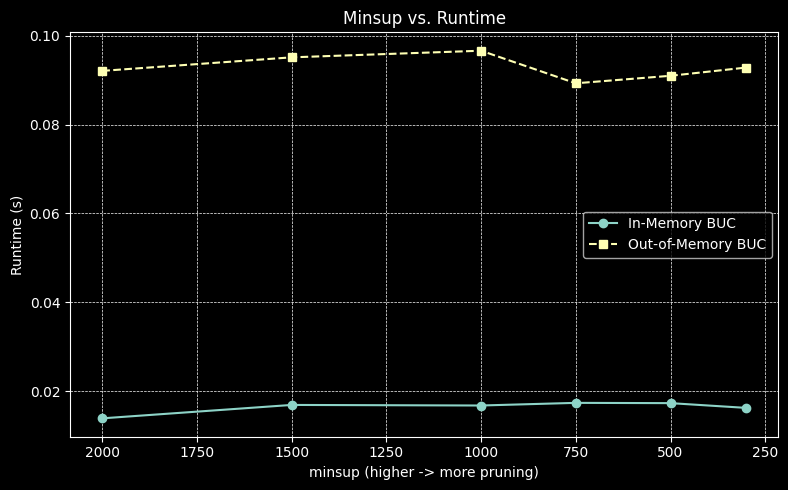

In [350]:
def bench_avg(runs, fn, *args, **kwargs):
    durs = []
    for _ in range(runs):
        start = time.perf_counter()
        fn(*args, **kwargs)
        durs.append(time.perf_counter() - start)
    return sum(durs) / len(durs)

minsup_values = [2000, 1500, 1000, 750, 500, 300]
in_mem_times, oom_times_minsup = [], []

print("Benchmark: minsup vs runtime (avg seconds)")
for ms in minsup_values:
    t_in_mem = bench_avg(1, buc_in_memory_baseline, buc_df[buc_dimensions], buc_dimensions, ms)
    in_mem_times.append(t_in_mem)

    t_oom = bench_avg(1, buc_out_of_memory, DATASET_PATH, buc_dimensions, ms, CONCEPT_HIERARCHIES)
    oom_times_minsup.append(t_oom)
    print(f"  minsup={ms}: in_mem={t_in_mem:.4f}s, out_of_mem={t_oom:.4f}s")

plt.figure(figsize=(8, 5))
plt.plot(minsup_values, in_mem_times, marker='o', label='In-Memory BUC')
plt.plot(minsup_values, oom_times_minsup, marker='s', linestyle='--', label='Out-of-Memory BUC')
plt.gca().invert_xaxis()
plt.title("Minsup vs. Runtime")
plt.xlabel("minsup (higher -> more pruning)")
plt.ylabel("Runtime (s)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Minsup vs. Runtime Analysis
In-Memory BUC (Lower, Teal Line): The runtime is very low (around 0.015s - 0.02s) and relatively flat. This is because the dataset is small enough that the in-memory operations are extremely fast. The slight increase in runtime as minsup decreases (moving from left to right on the plot) is expected as lower minsup means less pruning, so the algorithm has to explore more branches of the cube.

Out-of-Memory BUC (Higher, Yellow Line): This version is consistently slower (around 0.09s - 0.10s). This performance gap is the cost of I/O. Instead of working at RAM speed, this algorithm is constantly reading from and writing temporary partition files to the disk, which is a lot slower.

# BUC vs AOI

### Use Cases
- **AOI**: Summarization and characterization. It generalizes a large, task-relevant dataset into a small set of high-level characteristic rules.
- **BUC**: Exploration and pre-computation. It computes an iceberg cube containing all cuboids that meet a minsup threshold. It prepares data for fast multi-dimensional querying OLAP.

### Insights Discovered
- **AOI**: Discovers qualitative, descriptive patterns. The output is a set of generalized rules that describe the target data.
- **BUC**: Discovers quantitative, granular facts. The output is a collection of specific counts for various attribute combinations.

### Computational Complexity
- **AOI**: Generally more efficient and scalable for its specific task of summarization. Its complexity is driven by the number of attributes and the depth of the concept hierarchies, not an exponential number of combinations. It stops generalizing once the `GENERALIZATION_THRESHOLD` is met.
- **BUC**: Can be computationally expensive as the number of potential cuboids is exponential ($2^d$, where $d$ is the number of dimensions). Its efficiency relies heavily on the Apriori pruning optimization (`if row_count < minsup: return`).

### Interpretability of Results
- **AOI**: Highly interpretable. The final output is designed to be a small set of simple rules that can be easily read and understood by a non-technical user.
- **BUC**: Low direct interpretability. The raw output is a large dictionary of tuples and counts. While this is the perfect data structure for a computer or an OLAP tool to query, it is not a human-readable summary.

### Scenarios for Preference
- Prefer AOI when:
  - The goal is to generate a quick, high-level summary of a specific data subset.
  - We need to present findings to a non-technical audience (e.g., management).
- Prefer BUC when:
  - The goal is to enable interactive, ad-hoc data exploration and analysis (OLAP).
  - We need to answer a wide variety of specific, quantitative queries quickly.

---